# Feature extraction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## DAS data visualization

### 2D mapping

Using a scanning 2D window of 100x100 pixel dimension and step size of 10 pixels, we extract 32,901 images from a 1-minute 200-channel data file.

In [ ]:
import h5py,numpy
# Load image data
f = h5py.File('/content/drive/Shared drives/ML4DAS/RawData/1min_ch4650_4850/westSac_180112235258_ch4650_4850.mat','r')
data = numpy.array(f[f.get('variable/dat')[0,0]])
f.close()
# Get corner indexes of every images
img_size,stride = 100,10
idxs = numpy.array([[[i,j] for j in range(0,data.shape[1]-img_size+1,stride)] for i in range(0,data.shape[0]-img_size+1,stride)])
idxs = idxs.reshape(idxs.shape[0]*idxs.shape[1],2)
# Loop over images and extract data
Xtrain = []
for k,(i,j) in enumerate(idxs):
  Xtrain.append(data[i:i+img_size,j:j+img_size])
print('Full sampling side: {:,}'.format(len(Xtrain)))

Full sampling side: 32,901


Below is one example of a 100x100 data image extracted from the data where surface wave signals are clearly visible.

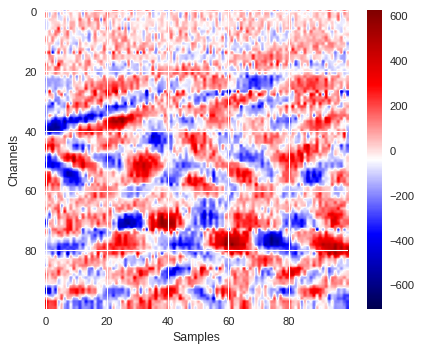

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=(5.5,4.5),dpi=80)
plt.imshow(Xtrain[400],aspect='auto',cmap='seismic')
plt.xlabel('Samples')
plt.ylabel('Channels')
plt.colorbar()
plt.tight_layout()
plt.show()

### 3D mapping

A 3-dimensional plot of the same data can be seen below using the same color scheme as above. The z axis represents the strain value for each of the 100 segments of the fibers and 100 samples in time. That is, each channel corresponds to individual strain measurement time series.

In [ ]:
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(18,8))
ax = plt.axes(projection='3d')
ax.view_init(elev=20,azim=-120)
X, Y = numpy.meshgrid(range(100),range(100))
ax.plot_surface(X, Y, Xtrain[400],cmap='seismic')
ax.set_xlabel('Samples')
ax.set_ylabel('Channels')
ax.set_zlabel('Strain measurement')
plt.show()

## Frequency content of DAS data

In this section, we will load some data and look at their frequency content.

### Fast Fourier Transform

The frequency content of a time series signal can be extracted using Fast Fourier Transform (FFT). Below is a very good video explained how FFT works.

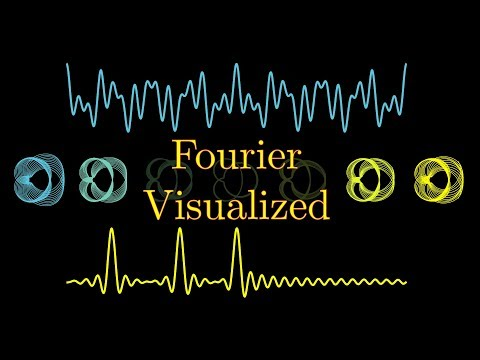

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('spUNpyF58BY')

Here, we consider channel 80 of the data region displayed above (that is, image index 400 from the `Xtrain` list). We use the [`scipy.fft.fft`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html#scipy.fft.fft) method from the Scipy python package to perform the FFT. This can be executed as follows:

In [ ]:
import scipy
fs = 500.                  # Data frequency (or sampling rate), that is number of sample in one second
ts = Xtrain[400][80]       # DAS data time series
ts_fft = scipy.fft.fft(ts) # Fourier transform of the input time series

The frequencies associated to the FFT array can be extracted using the [`scipy.fft.fftfreq`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftfreq.html#scipy.fft.fftfreq) method.

In [ ]:
import scipy
freqs = scipy.fft.fftfreq(len(ts_fft),d=1/fs)
print(freqs)

[   0.    5.   10.   15.   20.   25.   30.   35.   40.   45.   50.   55.
   60.   65.   70.   75.   80.   85.   90.   95.  100.  105.  110.  115.
  120.  125.  130.  135.  140.  145.  150.  155.  160.  165.  170.  175.
  180.  185.  190.  195.  200.  205.  210.  215.  220.  225.  230.  235.
  240.  245. -250. -245. -240. -235. -230. -225. -220. -215. -210. -205.
 -200. -195. -190. -185. -180. -175. -170. -165. -160. -155. -150. -145.
 -140. -135. -130. -125. -120. -115. -110. -105. -100.  -95.  -90.  -85.
  -80.  -75.  -70.  -65.  -60.  -55.  -50.  -45.  -40.  -35.  -30.  -25.
  -20.  -15.  -10.   -5.]


The `fft` method will output a complex array from which the phase and magnitude can be extracted from rate of -250 to +250 Hz. Below, we calculate the magnitude by taking the square root of the quadratic sum of both real and imaginary parts. This is equivalent of taking the absolute values of the FFT array.

In [ ]:
fft_mag = numpy.sqrt(ts_fft.real**2+ts_fft.imag**2)
fft_pha = numpy.arctan2(ts_fft.imag,ts_fft.real)

The DAS data are sampled at 500Hz, meaning that the period between 2 consecutive samples is 2ms (inverse of sampling rate). The Nyquist limit, for which signals can be fully reconstructed, is 250Hz (half the sampling rate) and correspond to the highest frequency available in the frequency domain. The lowest frequency limit correspond to the inverse of total time length of the data (that is, 100 samples / 500Hz = 0.2 second), so 5Hz.

In [ ]:
N = len(ts_fft)    # Total number of samples in the time series
Nyquist = fs/2      # Nyquist limit, fastest signal identifiable or maximum frequency of signal that can be fully reconstructed
T = 1/fs            # Time period between two consecutive data samples
duration = N/fs     # Total time duration of the time series in seconds
fmin = 1/duration   # Slowest signal identifiable

Below we plot both phase and magnitude data from the calculated complex FFT results.

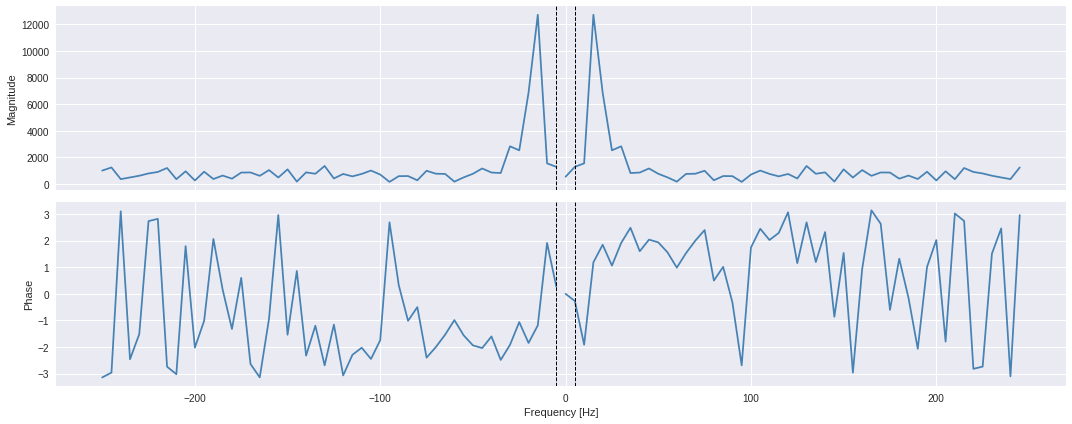

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
fig,ax = plt.subplots(2,1,figsize=(15,6))
for i,signal in enumerate([fft_mag,fft_pha]):
  ax[i].plot(freqs[N//2:],signal[N//2:],color='steelblue')
  ax[i].plot(freqs[:N//2],signal[:N//2],color='steelblue')
  ax[i].axvline(-fmin,ls='dashed',color='black',lw=1)
  ax[i].axvline(+fmin,ls='dashed',color='black',lw=1)
ax[0].set_ylabel('Magnitude')
ax[0].xaxis.set_ticklabels([])
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Phase')
plt.tight_layout()
plt.show()

In general, to return a FFT amplitude equal to the amplitude signal which you input to the FFT, you need to normalize FFTs by the number of sample points you're inputting to the FFT.

In [ ]:
ts_fft = 2.0/N*fft_mag[:N//2]
freqs = numpy.linspace(fmin,Nyquist,N//2)

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
fig,ax = plt.subplots(1,2,figsize=(18,5))
ax[0].plot(numpy.linspace(0,N/fs,N),ts)
ax[0].set_xlabel('Time [second]')
ax[0].set_ylabel('Strain measurement')
ax[1].plot(freqs,ts_fft)
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Magnitude')
plt.tight_layout()
plt.show()

### Frequency/channel visualization

In [ ]:
region = Xtrain[400]
ffts = numpy.array([2.0/len(time_serie)*numpy.abs(fft(time_serie)[:len(time_serie)//2]) for time_serie in region])

In [ ]:
from matplotlib.colors import LogNorm
plt.style.use('seaborn')
plt.figure(figsize=(5.5,4.5),dpi=80)
plt.imshow(ffts,extent=[fmin,Nyquist,ffts.shape[0],0],aspect='auto',cmap='jet',norm=LogNorm())
plt.xlabel('Frequency [Hz]')
plt.ylabel('Channels')
plt.colorbar()
plt.tight_layout()
plt.show()

### Average magnitude across channels

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm
def frequency_plot(data,region,ffts,channel,sample,fs=500):
  # Setup multiplot figure
  plt.style.use('seaborn')
  fig, ax = plt.subplots(1,4,figsize=[11,3],dpi=80)
  # Show larger image
  samp_min,samp_max = (0,fs//2) if sample<fs//2 else (data.shape[1]-fs//2,data.shape[1]) if sample>data.shape[1]-fs//2 else (sample-fs//2,sample+fs//2)
  ax[0].imshow(data[:,samp_min:samp_max],aspect='auto',cmap='binary')
  ax[0].set_ylabel('Channels')
  ax[0].set_xlabel('Sample %s to %s'%(samp_min,samp_max))
  ax[0].add_patch(Rectangle((sample-samp_min,channel),region.shape[1],region.shape[0],fill=False,edgecolor='yellow',lw=3))
  # Select and plot training image
  ax[1].imshow(region,extent=[0,region.shape[1],region.shape[0],0],aspect='auto',cmap='binary')
  ax[1].set_xlabel('Sample')
  # Do and plot FFT for each channel
  ax[2].imshow(ffts,extent=[2/region.shape[1]*fs,fs/2,region.shape[0],0],aspect='auto',norm=LogNorm(vmin=ffts.min(), vmax=ffts.max()),cmap='jet')
  ax[2].set_xlabel('Frequency [Hz]')
  # Plot average amplitude for each frequency
  x=numpy.linspace(2/region.shape[1]*fs,fs/2,ffts.shape[1])
  y=[numpy.average(freq) for freq in ffts.T]
  ax[3].plot(x,y)
  ax[3].set_xlabel('Frequency [Hz]')
  ax[3].set_xlim(2/region.shape[1]*fs,fs/2,region.shape[0])
  plt.tight_layout()
  plt.show()

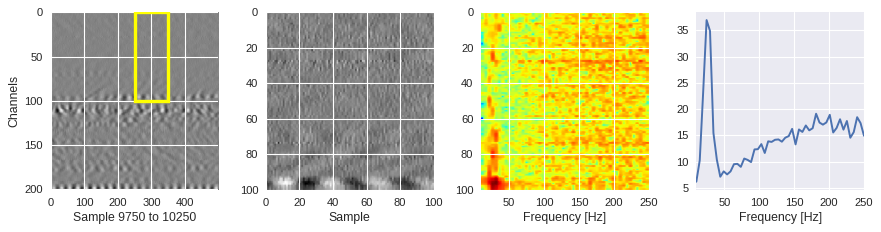

In [ ]:
from scipy.fft import fft
for idx in [1000,2000,200]:
  channel,sample = idxs[idx]
  region = Xtrain[idx]
  ffts = numpy.array([2.0/len(time_serie)*numpy.abs(fft(time_serie)[:len(time_serie)//2]) for time_serie in region])
  frequency_plot(data,region,ffts,channel,sample)

## Filtering out the noise

Let's consider the same data region (index 400 of the `Xtrain` list) and same channel (80) used before. In this section, we will show two different methods that can be used to remove all the high frequency signals which are the signatures of the noise. 

In [ ]:
ts = Xtrain[400][80]   # Single DAS data time series
N = len(ts)            # Total number of samples in time series
fs = 500.              # Sampling rate

### Method 1: Inverse Fourier transform

We first calculate the FFT and its corresponding frequency array using the `scipy.fft` library as follows:

In [ ]:
import scipy
ts_fft = scipy.fft.fft(ts)
freqs = scipy.fft.fftfreq(len(ts_fft),d=1/fs)

In order to manually cut off all high frequencies in the frequency domain, we loop through the frequency array and set to zero the FFT values for which the associated absolute frequency is greater than the cutoff frequency.

In [ ]:
cutoff = 75
for i in range(len(freqs)):
  if abs(freqs[i])>cutoff:
    ts_fft[i]=0.

Once the FFT is modified to filter out high frequency signals. The inverse Fourier transform can be applied to the altered FFT to get the now-filtered time series.


In [ ]:
import scipy
inverse = scipy.fft.ifft(ts_fft).real

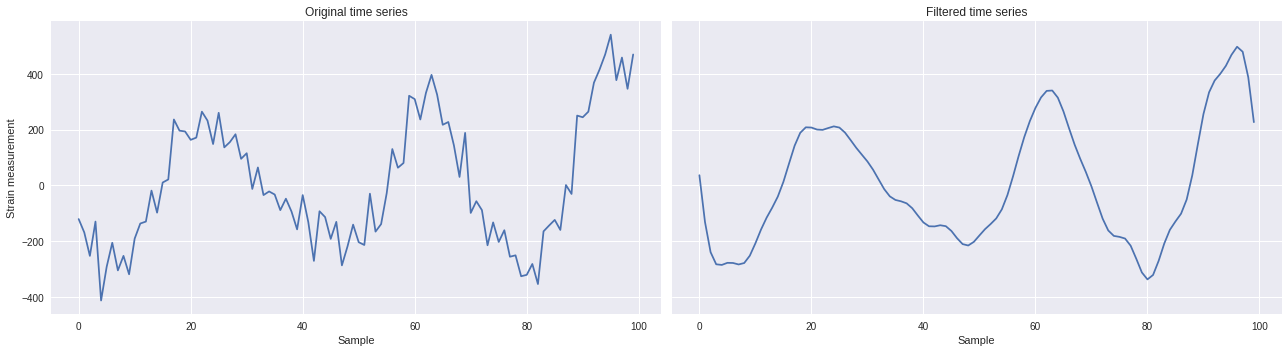

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
fig,ax = plt.subplots(1,2,figsize=(18,5),sharex=True,sharey=True)
ax[0].plot(ts)
ax[0].set_xlabel('Sample')
ax[0].set_ylabel('Strain measurement')
ax[0].set_title('Original time series')
ax[1].plot(inverse)
ax[1].set_xlabel('Sample')
ax[1].set_title('Filtered time series')
plt.tight_layout()
plt.show()

### Method 2: Low-pass filtering

A second method is to apply a low-pass filter. This can be achieved in two step. First, we design a Butterworth filter using the [`scipy.signal.butter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html#scipy.signal.butter) method by specifying order, N, of the filter and the cutoff frequency, Wn. Here, we choose to apply a 8-th order filter with a cutoff frequency at 75Hz. Note that the analog parameter must be set to `False` in order to return a digital filter and not analog.

In [ ]:
from scipy import signal
cutoff = 75
b, a = signal.butter(4, cutoff/(0.5*fs), btype='low', analog=False)

One can in fact visualize how the filter behaves using the [`scipy.signal.freqs`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqs.html#scipy.signal.freqs) method, which c theomputes frequency response of the analog filter.



In [ ]:
import matplotlib.pyplot as plt
w, h = signal.freqs(b, a)
plt.style.use('seaborn')
plt.figure(figsize=[11,4],dpi=80)
plt.semilogx(w, 20 * numpy.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(75/nyq, color='green')
plt.tight_layout()
plt.show()

The filtered time series can then be retrieved using the [`scipy.signal.filtfilt`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.filtfilt.html#scipy.signal.filtfilt) method as follows:

In [ ]:
from scipy import signal
ts_filt = signal.filtfilt(b, a, ts)

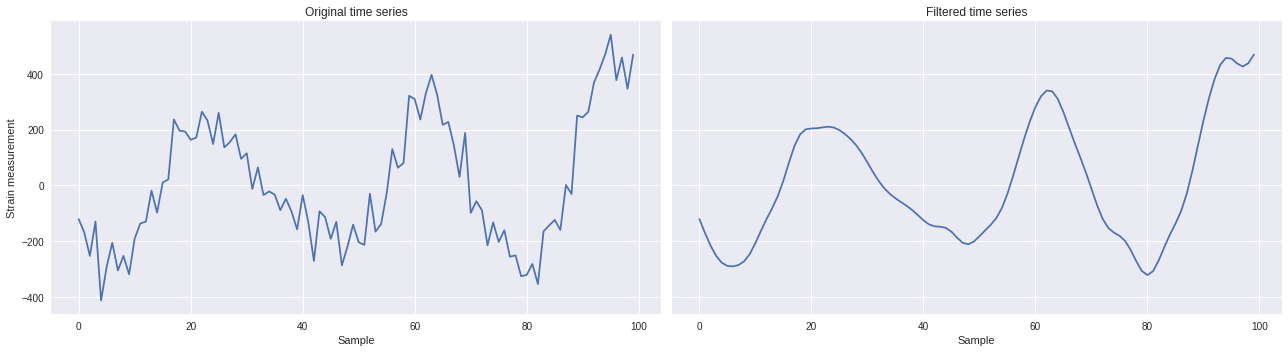

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
fig,ax = plt.subplots(1,2,figsize=(18,5),sharex=True,sharey=True)
ax[0].plot(ts)
ax[0].set_xlabel('Sample')
ax[0].set_ylabel('Strain measurement')
ax[0].set_title('Original time series')
ax[1].plot(ts_filt)
ax[1].set_xlabel('Sample')
ax[1].set_title('Filtered time series')
plt.tight_layout()
plt.show()


### Filtered 2D maps

The function below converts any input 2D time series region into FFT regions.

In [ ]:
from scipy import signal
def fft_map(region,fs=500,cutoff=75,order=4):
  b, a = signal.butter(order,cutoff/(fs/2), btype='low', analog=False)
  data_map = numpy.zeros(region.shape)
  for i,ts in enumerate(region):
    data_map[i] = signal.filtfilt(b, a, ts)
  return data_map

In [ ]:
region = Xtrain[2000]
data_map = fft_map(region)

We can plot a couple of region, one with surface waves and another without, and compare the original with the filtered versions.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
def compare_plot(region,data_map):
  plt.style.use('seaborn')
  fig,ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
  ax[0].imshow(region,extent=[0,region.shape[1],region.shape[0],0],aspect='auto',cmap='seismic')
  ax[0].set_xlabel('Sample')
  ax[0].set_ylabel('Channel')
  ax[0].set_title('Original region')
  ax[1].imshow(data_map,extent=[0,data_map.shape[1],data_map.shape[0],0],aspect='auto',cmap='seismic')
  ax[1].set_xlabel('Sample')
  ax[1].set_title('Filtered region')
  plt.tight_layout()
  plt.show()

In [ ]:
compare_plot(Xtrain[400],fft_map(Xtrain[400]))
compare_plot(Xtrain[31910],fft_map(Xtrain[31910]))

## Impact on data distribution

In the notebook on Variational Auto-Encoder, we looked at how the strain measurements are distributed for a full 1-minute file, individual patches, and separate output labeled datasets. In this section, we will investigate how filtering the data from the training images can provide smoother, more optimal training datasets for subsequent supervised learning models. We will look at double gaussian fits which have shown to provide more accurate approximation of the distribution than simple single gaussian fits.

In [ ]:
def gauss_single(x, a, b, c):
    return a * numpy.exp(-(x - b)**2.0 / (2 * c**2))
def gauss_double(x, a, b, c, d, e, f):
    return a * numpy.exp(-(x - b)**2.0 / (2 * c**2)) + d * numpy.exp(-(x - e)**2.0 / (2 * f**2))

The function below will plot the target distribution and fit it with double gaussian profile.

In [ ]:
import numpy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
def distfit(ax,data,ngauss=2,bins=150):
  hist = ax.hist(data.reshape(numpy.prod(data.shape)),bins=bins,range=[-750,750])
  # Fit double gaussian
  x = numpy.array([0.5 * (hist[1][i] + hist[1][i+1]) for i in range(len(hist[1])-1)])
  y = hist[0]
  fct = gauss_single if ngauss==1 else gauss_double
  popt, pcov = curve_fit(fct,x,y,p0=[200,0,80]*ngauss)
  # Calculate chi-square
  r = (y - fct(x, *popt))
  sigma = numpy.sqrt(numpy.diag(pcov))
  chisq = numpy.sum((r/numpy.average(sigma))**2)
  df = len(x) - len(popt)
  # Plot double gaussian
  x = numpy.arange(-750,750,0.001)
  y = fct(x, *popt)
  if ngauss==1:
    ax.plot(x, y, lw=2,color='salmon',label='Single-gaussian fit $\chi^2=%.4f$\n$\mu=%.2f, \sigma=%.3f$'%(chisq/df,popt[1],abs(popt[2])))
  if ngauss==2:
    ax.plot(x, y, lw=2,color='salmon',label='Double-gaussian fit $\chi^2=%.4f$'%(chisq/df))
    # Plot first gaussian
    y = gauss_single(x, *popt[:3])
    ax.plot(x, y, lw=2,color='yellow',label=r'$\mu=%.2f, \sigma=%.3f$'%(popt[1],abs(popt[2])))
    # Plot second gaussian
    y = gauss_single(x, *popt[3:])
    ax.plot(x, y, lw=2,color='palegreen',label=r'$\mu=%.2f, \sigma=%.3f$'%(popt[4],abs(popt[5])))
  ax.set_xlim(-750,750)
  ax.legend(loc='best')

Below we show how the filtering impacts the distribution of data from the training sets. In the case of surface wave images, the filtering allows to make the broader component (gaussian with large sigma reflecting surface wave patterns) the strongest (highest amplitude). For noise images, filtering the data will get rid of broad gaussian profiles and reduce the information to narrow gaussian profiles, which are the signature of white noise signals.

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
fig,ax = plt.subplots(2,2,figsize=(18,10),dpi=80)
ax[0][0].set_title('Unfiltered surface wave training image')
distfit(ax[0][0],Xtrain[400])
ax[0][1].set_title('Filtered surface wave training image')
distfit(ax[0][1],fft_map(Xtrain[400]))
ax[1][0].set_title('Unfiltered noise training image')
distfit(ax[1][0],Xtrain[31910])
ax[1][1].set_title('Filtered noise training image')
distfit(ax[1][1],fft_map(Xtrain[31910]))
plt.tight_layout()
plt.show()